# Basic imports

In [134]:
import re
import pdfplumber
from spacy.lang.nb import Norwegian
import spacy
import numpy as np

In [135]:
# Variables
names = ["Regional planstrategi", 
    "Kommunens kirkepolitikk", 
    "Kommuneplan for smabathavner", 
    "Strategiplan kultur", 
    "Havbruk", 
    "Temaplan for arbeid mot fattigdom", 
    "Barnefattigdom", 
    "Psykisk helse og rus plan"]

sdgNames = {
    1: "Utrydde fattigdom",
    2: "Utrydde sult",
    3: "God helse og livskvalitet",
    4: "God utdanning",
    5: "Likestilling mellom kjønnene",
    6: "Rent vann og sanitærforhold",
    7: "Ren energi til alle",
    8: "Anstendig arbeid og økonomisk vekst",
    9: "Industri, innovasjon og infrastruktur",
    10: "Mindre ulikhet",
    11: "Bærekraftige byer og lokalsamfunn",
    12: "Ansvarlig forbruk og produksjon",
    13: "Stoppe klimaendringene",
    14: "Livet i havet",
    15: "Livet på land",
    16: "Fred, rettferdighet og velfungerende institusjoner",
    17: "Samarbeid for å nå målene",
}

sdgColor = {
    1: "e5233a",
    2: "dda63a",
    3: "4b9f38",
    4: "c5182c",
    5: "ff3920",
    6: "25bde2",
    7: "fcc30b",
    8: "a21941",
    9: "fd6824",
    10: "dd1367",
    11: "fd9d23",
    12: "bf8b2d",
    13: "407e44",
    14: "0a97d9",
    15: "56c02b",
    16: "00689d",
    17: "184769",
}


# Helper functions

In [136]:
def pdfToText(fileName, name):
    """
    Create string from pdf and save as .txt file if file doesn't exist. Returns string.
    """
    all_text = ""
    with pdfplumber.open(fileName) as pdf:
        for page in pdf.pages:
            all_text += page.extract_text()
    # print(all_text)
    all_text = re.sub('\s', ' ', all_text)
    # print(all_text)
    with open(f"txt/{name}.txt", "w") as f:
        f.write(all_text)
    if not name in names:
        names.append(name)
    return all_text

In [ ]:
def pdfToTextPages(fileName, name):
    """
    Create list of strings from pdf. Each string is the text on 1 page in the pdf. Return list.
    """
    textList = []
    with pdfplumber.open(fileName) as pdf:
        for page in pdf.pages:
            textPage = page.extract_text()
            textPage = re.sub('\s', ' ', textPage)
            textList.append(textPage)
    # TODO implement saving of list of str to .txt and function for loading .txt to list of str
    
    # print(all_text)
    # with open(f"txt/{name}.txt", "w") as f:
    #     f.write(all_text)
    # if not name in names:
    #     names.append(name)
    return textList

In [ ]:
def txtToStr(filename):
    """
    Read .txt file into string and return string.
    """
    f = open(filename, 'r')
    textLines = f.readlines()
    text = ""
    for line in textLines:
        text += line
    text = re.sub('\s', ' ', text)
    return text

# Scraping

No need to run if "sdg#.txt" in "sdgs" folder is present.

In [ ]:
# Scraping imports and inits
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
driver = webdriver.Chrome(ChromeDriverManager().install())
from bs4 import BeautifulSoup as BS

In [ ]:
# Scraping sdgs from FN.
sdgs = []
driver.get("https://www.fn.no/om-fn/fns-baerekraftsmaal")
soup = BS(driver.page_source, features="html.parser")
title_cards = soup.find_all(class_="header_gols_content_item")
for card in title_cards:
    a = card.find("a", href=True)
    sdgs.append(a["href"])
print(sdgs)
i = 1
for sdg in sdgs:
    driver.get(f"https://www.fn.no/{sdg}")
    soup = BS(driver.page_source, features="html.parser")
    paragraphs = soup.find_all("p")
    f = open(f'sdgs/sdg{i}.txt', 'w')
    for par in paragraphs:
        line = par.text.strip()
        line = line.replace('...', '')
        line = line.replace('&aelig;', 'æ')
        if len(line) > 0:
            if not line[-1] in ".?!:)":
                line += '.'
            f.write(f'{line}\n')
    f.close()
    i += 1

# PDF scraping
Make pdfs as .txt in /txt folder

In [ ]:
regPlan = pdfToText('pdfs/regional-planstrategi-2016-2010.pdf', "Regional planstrategi")
kirkepol = pdfToText('pdfs/050200-sak-kommunens-kirkepolitikk.pdf', "Kommunens kirkepolitikk")
smabathavn = pdfToText('pdfs/kommunedelplan-for-smabathavner-2007-2017.pdf', "Kommuneplan for smabathavner")
kultur = pdfToText('pdfs/strategiplan-kultur-web.pdf', "Strategiplan kultur")
havbruk = pdfToText("pdfs/havbruk.pdf", "Havbruk")
fattigdomGammel = pdfToText("pdfs/temaplan-for-arbeid-mot-fattigdom.pdf", "Temaplan for arbeid mot fattigdom")
kvalKlubb = pdfToText("pdfs/bettinak,+{$userGroup},+R-18-2-SAM.pdf", "Barnefattigdom")
psykiskHelse = pdfToText("pdfs/psykiskhelseogrusplan.pdf", "Psykisk helse og rus plan")

# Wiki scraping

In [ ]:
import wikiscraper as ws
ws.lang("no")
abstractList = []
with open("randWiki.txt", "a") as file:
    for i in range(1000):
        result = ws.searchBySlug("Spesial:Tilfeldig")
        try:
            abstractList = result.getAbstract()
            for par in abstractList:
                if not "[rediger | rediger kilde]" in par:
                    file.write(par + "\n")
        except:
            pass

# Similarity (old method)

In [ ]:
def similarityText(mainStr, searchStr):
    """
    Return spacy similatiry based on vector in nb_core_news_lg.
    """
    nlp = spacy.load("nb_core_news_lg")

    mainDoc = nlp(mainStr)
    searchDoc = nlp(searchStr)

    mainTokenized = nlp(' '.join([str(token.lemma_) for token in mainDoc if not token.is_stop and not token.is_punct and not token.is_space]))
    searchTokenized = nlp(' '.join([str(token.lemma_) for token in searchDoc if not token.is_stop and not token.is_punct and not token.is_space]))
    # print(mainTokenized)
    # print(searchTokenized)
    return mainTokenized.similarity(searchTokenized)

In [ ]:
def sdgSimilatiry(string):
    """
    Print and return similarity of string to all SDGs.
    """
    valueList = []
    for sdg in range(17):
        value = similarityText(string, txtToStr(f"sdgs/sdg{sdg+1}.txt"))
        print(f"SDG #{sdg+1} has this similarity to your string: {value}")
        valueList.append(value)
    return valueList

In [ ]:
def addSdgVector(str, name):
    """
    Add similarity results to sdgVector.
    """
    return sdgSimilatiry(str)

# Predicting

In [ ]:
# for documentation see: https://www.kaggle.com/satishgunjal/tutorial-text-classification-using-spacy
import string
nlp = spacy.load("nb_core_news_lg")
parser = Norwegian()
punctuations = string.punctuation
stop_words = spacy.lang.nb.stop_words.STOP_WORDS
def spacy_tokenizer(sentence):
    """This function will accepts a sentence as input and processes the sentence into tokens, performing lemmatization, 
    lowercasing, removing stop words and punctuations."""
    
    # Creating our token object which is used to create documents with linguistic annotations
    mytokens = nlp(sentence)
    
    # lemmatizing each token and converting each token in lower case
    # Note that spaCy uses '-PRON-' as lemma for all personal pronouns lkike me, I etc
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations]
    # Return preprocessed list of tokens
    return mytokens

In [ ]:
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        """Override the transform method to clean text"""
        return [clean_text(text) for text in X]
    
    def fit(self, X, y= None, **fit_params):
        return self
    
    def get_params(self, deep= True):
        return {}

# Basic function to clean the text
def clean_text(text):
    """Removing spaces and converting the text into lowercase"""
    return text.strip().lower()

## Trainingdata

In [ ]:
"""
Creating trainingdata for classifying SDGs with UN data. Tagged 1-17 for what # sdg it is related to.
"""
X_train = []
y_train = []
for i in range(17):
    f = open(f'sdgs/sdg{i+1}.txt')
    for line in f:
        line = re.sub('\s', ' ', line)
        X_train.append(line)
        y_train.append(i+1)

"""
Creating traingdata for boolean classifying with random wiki corpus. Tagged 0 for sdg relation and 1 for wiki.
"""

X_train2 = []
y_train2 = []
for i in range(17):
    with open(f'sdgs/sdg{i+1}.txt', 'r') as f:
        for line in f:
            line = re.sub('\s', ' ', line)
            X_train2.append(line)
            y_train2.append(0)

with open('txt/randWiki.txt', 'r') as f:
    for line in f:
        line = re.sub('\s', ' ', line)
        X_train2.append(line)
        y_train2.append(1)

"""
Creating traingdata for boolean classifying with NoReC corpus. Tagged 0 for sdg relation and 1 for wiki.
"""
import os
import glob

path = 'dev-kopi/'
X_train3 = []
y_train3 = []
stop = 0
for filename in glob.glob(os.path.join(path, '*.txt')): # open all .txt files in "dev-kopi" folder.
   with open(os.path.join(os.getcwd(), filename), 'r') as f:
      if stop < 10000: # stop at 10000 for testing purposes. 133000 lines in total, but takes very long to train.
         for line in f:
            line = re.sub('\s', ' ', line)
            if len(line) != 1:
               X_train3.append(line)
               y_train3.append(1)
               stop += 1

for i in range(17):
    with open(f'sdgs/sdg{i+1}.txt', 'r') as f:
        for line in f:
            line = re.sub('\s', ' ', line)
            X_train3.append(line)
            y_train3.append(0)

In [ ]:
from sklearn.linear_model import LogisticRegression  
from sklearn.feature_extraction.text import TfidfVectorizer

def createPipe(trainingData):
    """ 
    Create pipeline using Tf-idf. Returns pipeline trained on trainingdata
    """
    pipe = Pipeline ([("cleaner", predictors()),
                 ("vectorizer", TfidfVectorizer(tokenizer=spacy_tokenizer)),
                 ("classifier", LogisticRegression(multi_class='ovr', solver='liblinear'))])
    pipe.fit(trainingData[0], trainingData[1])
    return pipe

pipeIndividual = createPipe([X_train, y_train])
# pipeBoolean = createPipe([X_train2, y_train2])

In [ ]:
pipeBooleanNew = createPipe([X_train3, y_train3])

In [ ]:
def tfidfModel(testData, pipe):
    """
    Return predicted probabilities for Pipeline (pipe).
    """

    predicted = pipe.predict_proba(testData)
    return predicted

# Plotting

In [ ]:
import matplotlib.pyplot as plt

def sdgList(predictions, threshold=0.75):
    """
    Returns predicted probabilities for all SDG's as a list, adjusted for given threshold. Values above 1 is returned as 1
    """
    sdgTrue = len(predictions)*[0]
    for i in range(len(predictions)):
        if predictions[i] > 1:
            sdgTrue[i] = 1
        elif predictions[i] - threshold > 0:
            sdgTrue[i] = (predictions[i] - threshold) / (1 - threshold)
        else:
            sdgTrue[i] = 0
    return sdgTrue


In [ ]:
def probabilityCombine(bool, individual, numSdg = 17):
    """
    Returnes combined boolean and individual predictions.
    """
    mult = individual * numSdg
    for i in range(len(mult)):
        mult[i] *= bool[i][0]
    return mult


def plotTestTextPredictions(testText, names = None, threshold = 0.75):
    """
    Plots predictions for a given string to be related to each sdg # (1-17)
    """
    barekraftBool = tfidfModel(testText, pipeBooleanNew)
    # print(barekraftBool)
    # barekraftBoolOld = tfidfModel(testText, pipeBoolean)
    # print(barekraftBoolOld)
    sdgPredictions = tfidfModel(testText, pipeIndividual)
    # print(sdgPredictions)

    sdgPredictionsMult = probabilityCombine(barekraftBool, sdgPredictions)

    sdgNames = []
    for i in range(17):
        sdgNames.append(i+1)
    num = 0
    for doku in sdgPredictionsMult:
        plt.figure()
        if names:
            plt.title(names[num])
        plt.ylim([0,1])
        plt.bar(sdgNames, sdgList(doku, threshold), 0.7)
        plt.xlabel("Bærekraftsmål")
        plt.ylabel("Sannsynlighet")
        plt.xticks(sdgNames)
        plt.show()
        num += 1

In [ ]:
def plotTestTextPredictionsNew(testText, names = None, threshold = 0.75):
    """
    Plots predictions for a given string to be related to each sdg # (1-17)
    """
    barekraftBool = tfidfModel(testText, pipeBooleanNew)
    # print(barekraftBool)
    # barekraftBoolOld = tfidfModel(testText, pipeBoolean)
    # print(barekraftBoolOld)
    sdgPredictions = tfidfModel(testText, pipeIndividual)
    # print(sdgPredictions)

    sdgPredictionsMult = probabilityCombine(barekraftBool, sdgPredictions)
    valueArray = np.transpose(np.array(sdgPredictionsMult))

    sdgNums = list(range(1,18))
    pages = list(range(1, np.size(valueArray, 1)+1))
    # plt.figure(figsize=(10,10))
    figure, axis = plt.subplots(17, 1, figsize=(10,17))
    for i in range(17):
        sdgValues = valueArray[i]
        
        # plt.title(sdgNames.get(i+1))
        axis[i].bar(pages,sdgList(sdgValues), 1, color=("#"+sdgColor.get(i+1)))
        axis[i].text(0.5,0.8, f'BKM {i+1}: {sdgNames.get(i+1)}', horizontalalignment='center', transform = axis[i].transAxes)
        axis[i].set_ylim([0,1])
        axis[i].set_xlim([1, np.size(sdgValues, 0)])
        axis[i].set_yticks([])
        if i != 16:
            axis[i].set_xticks([])
        
    plt.subplots_adjust(hspace=0)
    plt.show()

    for i in range(np.size(valueArray, 0)):
        valueArray[i] = sdgList(valueArray[i])
    num = 0

    # for doku in sdgPredictionsMult:
    #     plt.figure()
    #     if names:
    #         plt.title(names[num])
    #     plt.ylim([0,1])
    #     plt.bar(sdgNames, sdgList(doku, threshold), 0.7)
    #     plt.xlabel("Bærekraftsmål")
    #     plt.ylabel("Sannsynlighet")
    #     plt.xticks(sdgNames)
    #     plt.show()
    #     num += 1

# Testing

In [ ]:
barekraft = txtToStr("txt/barekraftSNL.txt")
store = txtToStr("txt/store.txt")

In [ ]:
print(names)

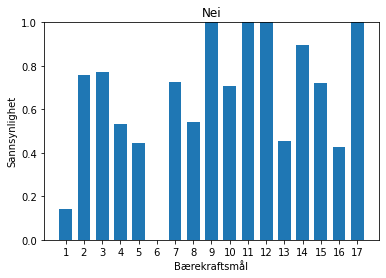

In [137]:
plotTestTextPredictions([regPlan], ["Nei"])

In [139]:
regPlanSider = pdfToTextPages("pdfs/regional-planstrategi-2016-2010.pdf", "nei")

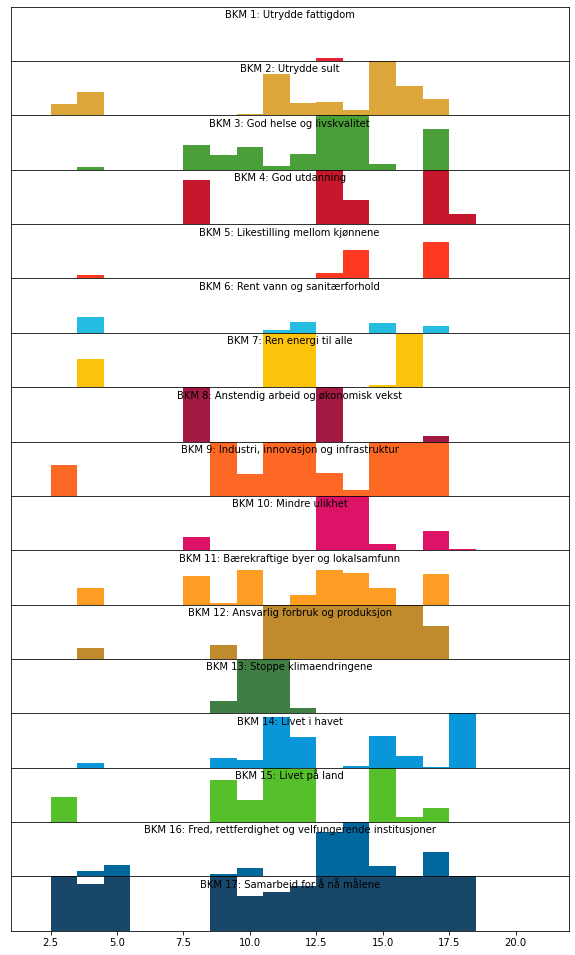

In [140]:
plotTestTextPredictionsNew(regPlanSider)

In [ ]:
skisse = pdfToText("pdfs/Skisse ny kommuneplanens samfunnsdel 2020-2032 - hoveddokument.pdf", "skisse")

In [ ]:
plotTestTextPredictions([skisse], ["Testdokument TK"])

In [ ]:
klima = pdfToText("pdfs/m443.pdf", "Klima")
plotTestTextPredictions([klima], ["Klima"])

In [ ]:
X_test = []
for name in names:
    X_test.append(txtToStr("txt/"+name+".txt"))
plotTestTextPredictions(X_test, names)
# plotTestTextPredictions([barekraft])

In [ ]:
regPlanSider = pdfToTextPages("pdfs/psykiskhelseogrusplan.pdf", "idk")


In [ ]:
skisseSider = pdfToTextPages("pdfs/Skisse ny kommuneplanens samfunnsdel 2020-2032 - hoveddokument.pdf", "ny")
sider = list(range(1,len(skisseSider)+1))


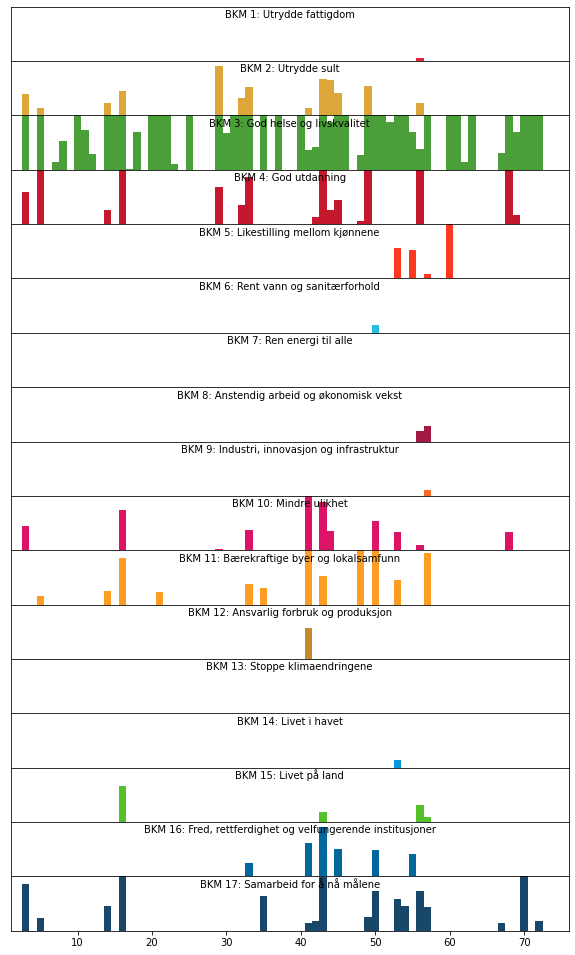

In [133]:
plotTestTextPredictionsNew(regPlanSider, sider, 0.5)

In [ ]:
sider = list(range(1,len(regPlanSider)+1))
plotTestTextPredictionsNew(regPlanSider, sider, 0.5)